In [75]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, confusion_matrix

In [120]:
train = pd.read_csv("train.csv", na_values=['na'])
validation = pd.read_csv("val.csv", na_values=['na'])
train.shape, validation.shape

((30000, 44), (23333, 44))

In [121]:
unlabeled = pd.read_csv("unlabeled_v2.csv", na_values=['na'])
unlabeled.shape

(23333, 43)

In [4]:
train['class'].value_counts()

2    10000
1    10000
0    10000
Name: class, dtype: int64

###  Functions

In [5]:
bands_all = ['u', 'g', 'r', 'i', 'z']
indx_all = ['0', '1', '2', '3', '4', '5', '6']

In [6]:
def show_missing_values():
    missing_values_df = pd.DataFrame(0, columns=['train', 'validation', 'unlabeled'], index=train.columns)

    missing_values_df['train'] = train.isna().sum()

    missing_values_df['unlabeled'] = unlabeled.isna().sum()
    missing_values_df.at['class', 'unlabeled'] = 0
    missing_values_df.unlabeled = missing_values_df.unlabeled.astype('int64')

    missing_values_df['validation'] = validation.isna().sum()

    return missing_values_df[missing_values_df.any(axis=1)]

In [7]:
def show_classes_distributions_by_index(idx, data):    
    fig, ax = plt.subplots(1, 5, figsize=(10, 3))
    fig.subplots_adjust(wspace=0.7)

    for j in range(5):
        f_name = "{}_{}".format(bands_all[j], idx)
        sns.boxplot(x='class', y=f_name, data=data, ax=ax[j])

# Data Exploration

In [31]:
train.head()

,objid,ra,dec,u_0,g_0,r_0,i_0,z_0,clean,rowc,...,g_5,r_5,i_5,z_5,u_6,g_6,r_6,i_6,z_6,class
0,78023,121.079395,-9.343143,25.46583,22.53827,21.52258,NaN,NaN,1,107.03430,...,-0.184090,-0.054633,NaN,NaN,6,5,6,5,2,0
1,67239,121.080753,-9.339397,23.64559,24.57786,21.76326,20.94348,21.52855,1,134.68570,...,0.371713,-0.128548,-0.122364,NaN,6,8,1,1,0,0
2,48461,121.070386,-9.332728,24.88126,23.49473,22.23877,21.38574,21.51635,1,84.76380,...,0.004125,0.014147,-0.051568,NaN,6,4,6,4,5,0
3,55564,121.083052,-9.334026,23.57384,21.42411,20.43948,19.99905,19.82959,1,177.05670,...,-0.080959,NaN,-0.089301,NaN,3,4,5,2,4,0
4,96180,121.063351,-9.325032,23.85167,20.25245,19.60670,19.18877,19.08231,1,65.37769,...,-0.037828,-0.097120,NaN,0.106472,3,4,7,6,3,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 44 columns):
objid    30000 non-null int64
ra       30000 non-null float64
dec      30000 non-null float64
u_0      25444 non-null float64
g_0      25496 non-null float64
r_0      25445 non-null float64
i_0      25404 non-null float64
z_0      25519 non-null float64
clean    30000 non-null int64
rowc     30000 non-null float64
colc     30000 non-null float64
rowv     29599 non-null float64
colv     29599 non-null float64
u_1      30000 non-null float64
g_1      30000 non-null float64
r_1      30000 non-null float64
i_1      30000 non-null float64
z_1      30000 non-null float64
u_2      30000 non-null float64
g_2      30000 non-null float64
r_2      30000 non-null float64
i_2      30000 non-null float64
z_2      30000 non-null float64
u_3      24827 non-null float64
g_3      28280 non-null float64
r_3      29273 non-null float64
i_3      29420 non-null float64
z_3      28272 non-null float64

In [10]:
train['class'].value_counts()

2    10000
1    10000
0    10000
Name: class, dtype: int64

## Visualization

The majority of features are different light observations, so let's see how they affect on classes. 

In [11]:
color_features = ["{}_{}".format(b, str(i)) for b in bands_all for i in range(6)]

train_colors = train[[*color_features, 'class']]
unlabeled_colors = unlabeled[[*color_features]]

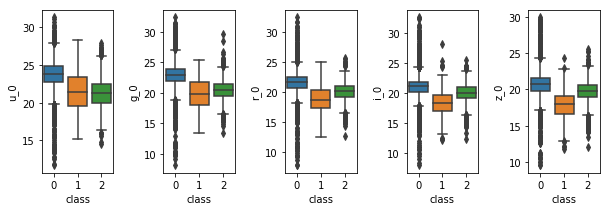

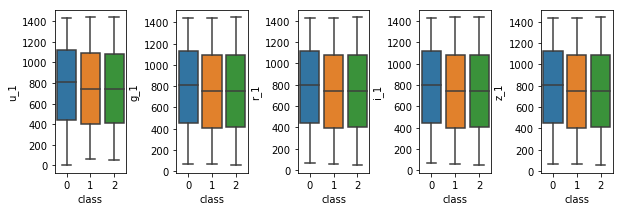

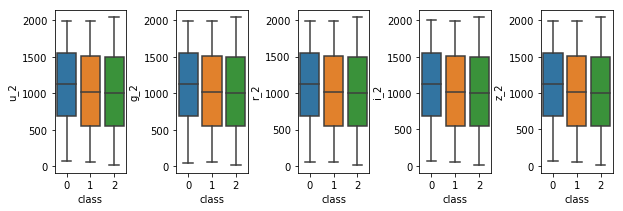

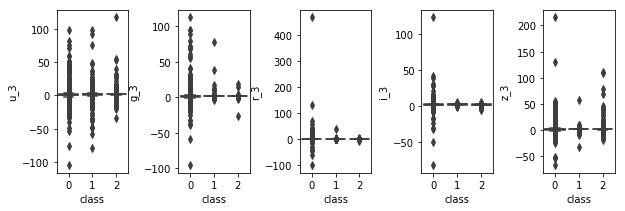

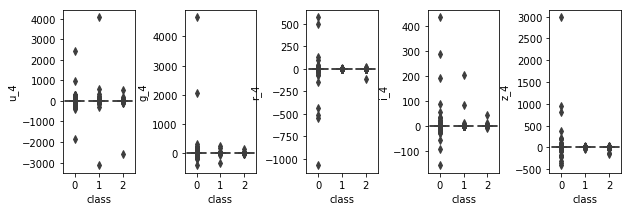

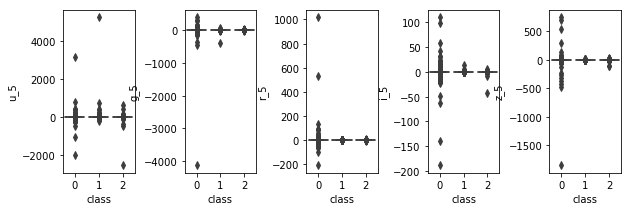

In [12]:
# plot only features which has real-type values
for i in ['0', '1', '2', '3', '4', '5']:
    show_classes_distributions_by_index(i, train_colors)

1-st and 2-nd features are a bit different from others: they don't have outliers, have bigger variance and nearly the same values for different classes    
3-rd, 4-th and 5-th features seem to have very small variance and no effect on class (and have a lot of outliers)   
To be sure let's investigate outliers and check again  

0-th feature has a bit differrent values for differrent classes and might be usefull while prediction, so let's investigate it more.

#### 3-th, 4-th and 5-th outliers

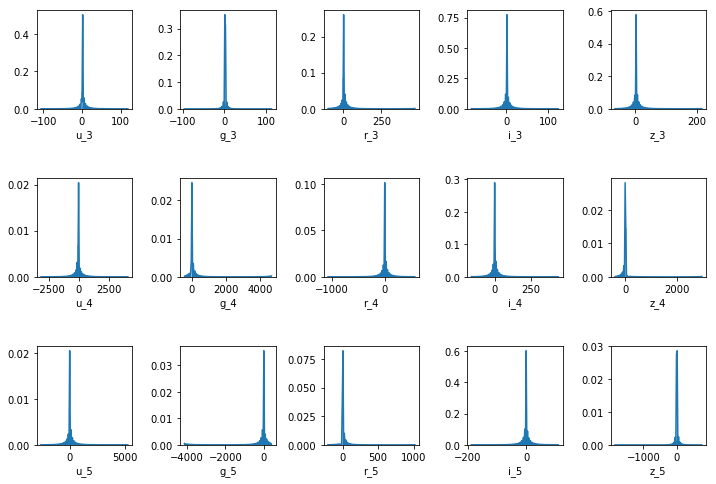

In [13]:
fig, ax = plt.subplots(3,5, figsize=(12,8))
fig.subplots_adjust(hspace=0.7, wspace=0.5)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        clean = train[train[f_name].notna()][f_name]
        sns.distplot(clean, ax=ax[i, j])
        j += 1
    i += 1


Using IQR to detect outliers

In [14]:
# detect and save outliers
features = ["{}_{}".format(b, str(i)) for i in range(3, 6) for b in bands_all]

Q1 = train[features].quantile(0.25)
Q3 = train[features].quantile(0.75)

IQR = Q3 - Q1

low_bound = Q1 - 1.5 * IQR
high_bound = Q3 + 1.5 * IQR

clean_data = {}
outliers = {}

for f in features:
    lower_outlier_mask = train[f] < low_bound[f]
    high_outlier_mask = train[f] > high_bound[f]
    
    clean_data[f] = train[~(lower_outlier_mask | high_outlier_mask)]
    outliers[f] = train[lower_outlier_mask | high_outlier_mask]
    print("{}: {} outliers".format(f, len(outliers[f])))

u_3: 1134 outliers
g_3: 4999 outliers
r_3: 2523 outliers
i_3: 1997 outliers
z_3: 4185 outliers
u_4: 5856 outliers
g_4: 4892 outliers
r_4: 3367 outliers
i_4: 2859 outliers
z_4: 3937 outliers
u_5: 6107 outliers
g_5: 5266 outliers
r_5: 3655 outliers
i_5: 3286 outliers
z_5: 3895 outliers


Try to find the reason for outliers

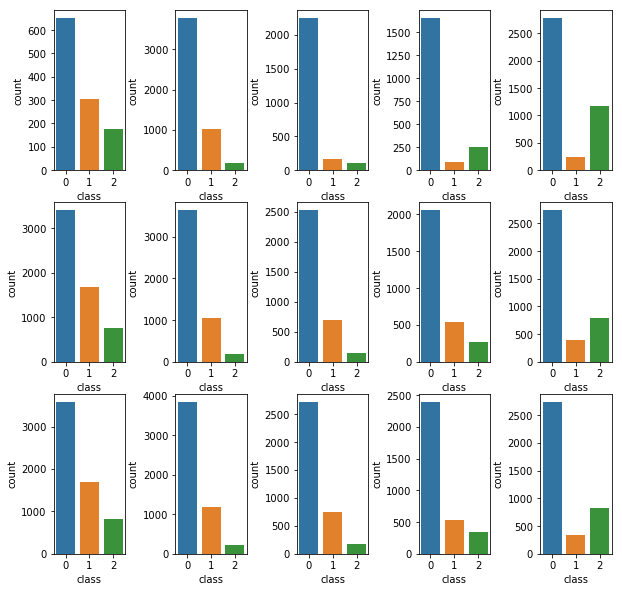

In [15]:
# classes

fig, ax = plt.subplots(3, 5, figsize=(10, 10))
fig.subplots_adjust(wspace=0.7)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        sns.countplot(x='class', data=outliers[f_name], ax=ax[i, j])
        j += 1
    i += 1

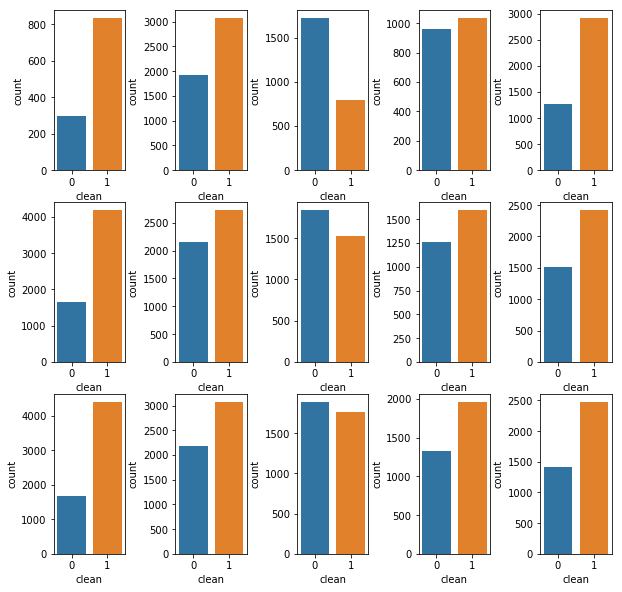

In [16]:
# clean 

fig, ax = plt.subplots(3, 5, figsize=(10, 10))
fig.subplots_adjust(wspace=0.7)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        sns.countplot(x='clean', data=outliers[f_name], ax=ax[i, j])
        j += 1
    i += 1

~ 10-20% of given features are outliers  
Outliers happen not due to 'noisy' shots (in most cases there are more outliers in clean shots)  
Samples of 0-th class has more outliers than 1-st and 2nd ones


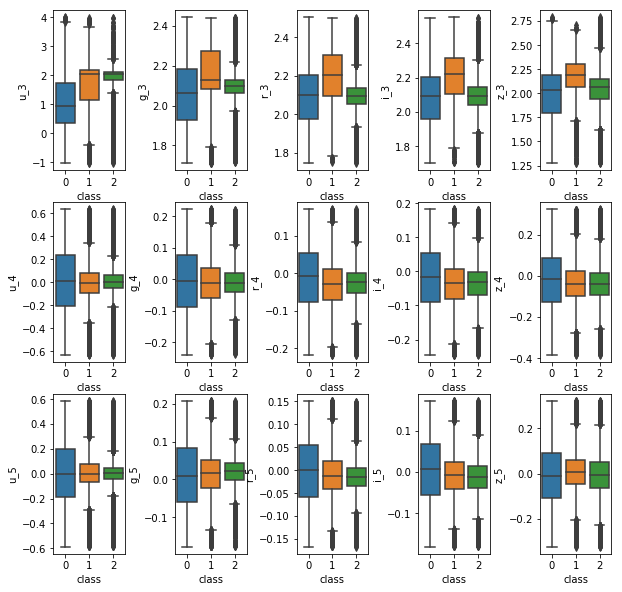

In [17]:
# plot again, without outliers
fig, ax = plt.subplots(3, 5, figsize=(10, 10))
fig.subplots_adjust(wspace=0.7)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        sns.boxplot(x='class', y=f_name, data=clean_data[f_name], ax=ax[i, j])
        j += 1
    i += 1
    

Even with outliers removed, 4-th and 5-th features seem to have the same values for each class.  
3-rd features are a bit different for different classes  


#### 0-th color features

0-th color features still have a lot of missing values, but they can probably be usefull while prediction.  
Check, if we can predict them from other features.

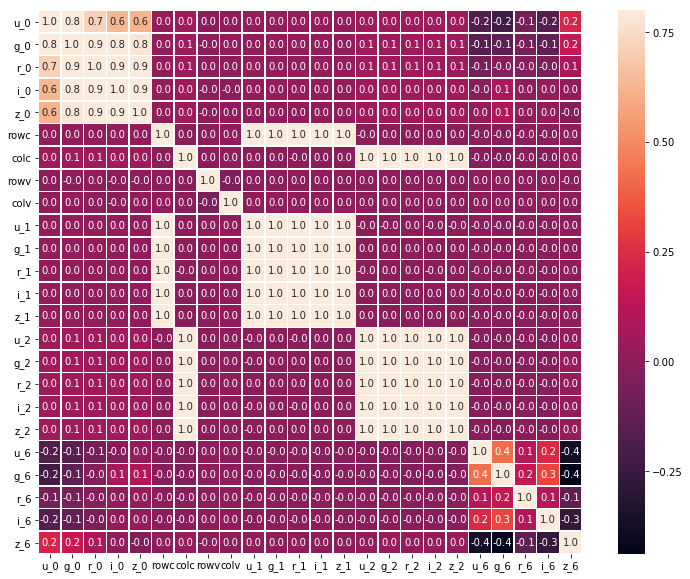

In [18]:
exclude_from_corrmap = ["{}_{}".format(b, n) for n in ['3', '4', '5'] for b in bands_all]
exclude_from_corrmap.extend(['class', 'objid', 'ra', 'dec', 'clean'])

corrmat = train.drop(exclude_from_corrmap, axis=1).corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corrmat,  annot=True, linewidths=.5, fmt= '.1f', vmax=.8, square=True)

0-th features in training set have strong corrlation with one another. ('u_0' and 'g_0', 'g_0' and 'r_0' and so on), so may be predicted one from another    

1-st and 2-nd features are perfectly correlated inside groups *(-_- hm)*   
Also, 1-st features are perfectly correlated with 'rowc' (O.O) and 2-nd features with 'colc' (why?) !!!!!

Check the same in unlabeled dataset

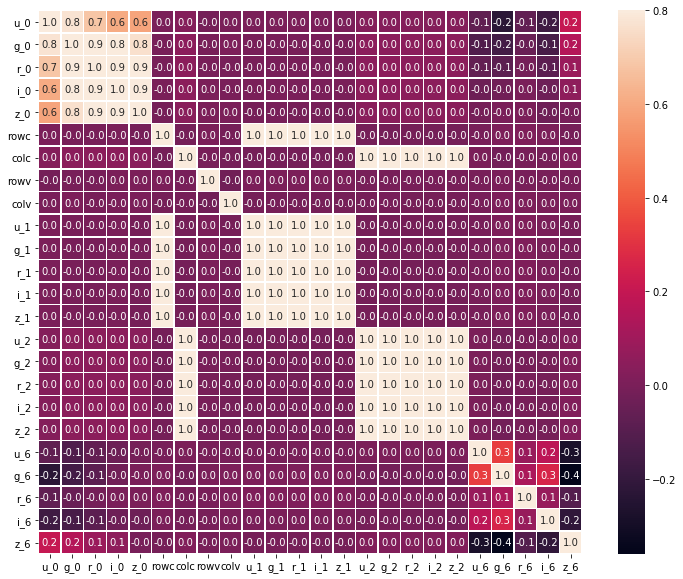

In [19]:
if 'class' in exclude_from_corrmap:
    exclude_from_corrmap.remove('class')

corrmat = unlabeled.drop(exclude_from_corrmap, axis=1).corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corrmat, annot=True, linewidths=.5, fmt= '.1f', vmax=.8, square=True)

#### Perfect correlation in 1-st and 2-nd features

Let's look closely on these perfectly correlated groups

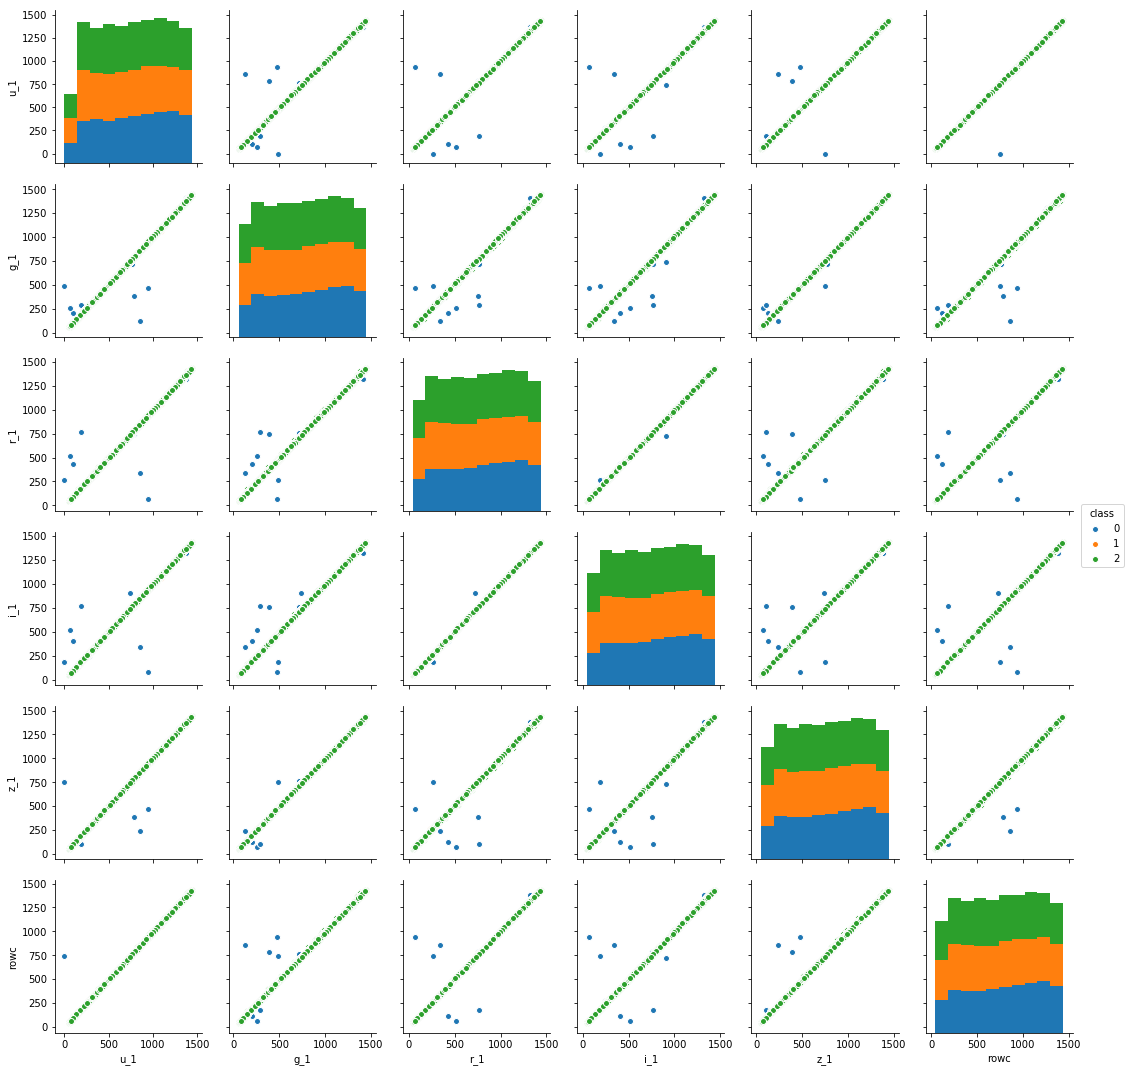

In [20]:
f_features = ["{}_1".format(b) for b in bands_all]
f_features.append('rowc')

group = train[[*f_features, 'class']]
sns.pairplot(group, hue='class', vars=f_features)


Perfect matching)  
Let's check another group

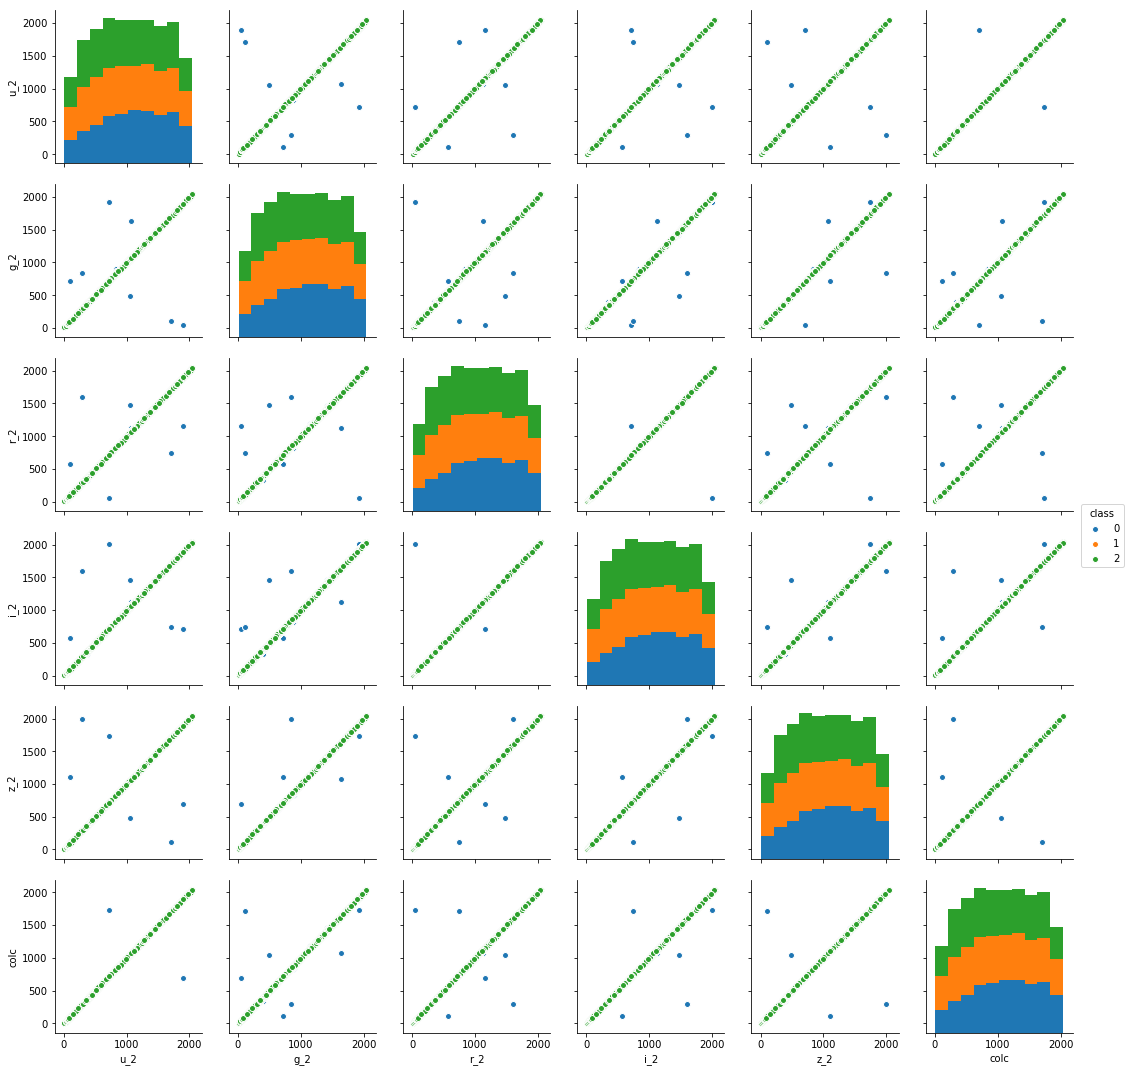

In [21]:
f_features = ["{}_2".format(b) for b in bands_all]
f_features.append('colc')

group = train[[*f_features, 'class']]
sns.pairplot(group, hue='class', vars=f_features)

Since features in each group are almost the same, and different class samples are evenly distributed though values let's keep only one feature from each group.

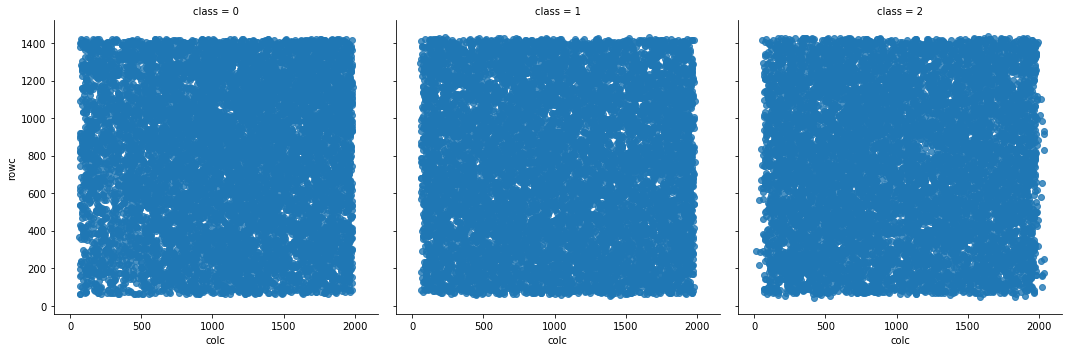

In [22]:
sns.lmplot(x='colc', y='rowc', data=train, col='class', fit_reg=False)

Values of features are evenly distributed in range [0, 2000] and [0, 1400], so it's likely coordinates of object in frame.  
Let's keep 'rowc' and 'colc' columns and drop 1-st and 2-nd features.

#### 6-th color feature

6-th color feature represents categorial data for a photometric measurment.  

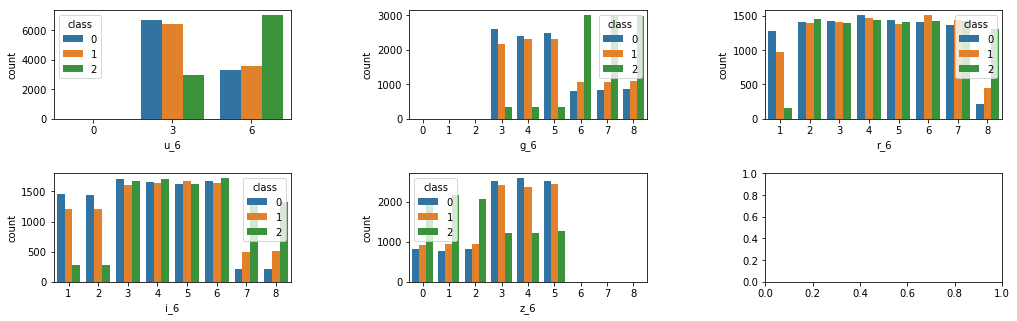

In [55]:
fig, ax = plt.subplots(2, 3, figsize=(17, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, b in enumerate(bands_all):
    f_name = "{}_6".format(b)
    sns.countplot(x=f_name, data=train, ax=ax[i // 3, i % 3], hue='class')

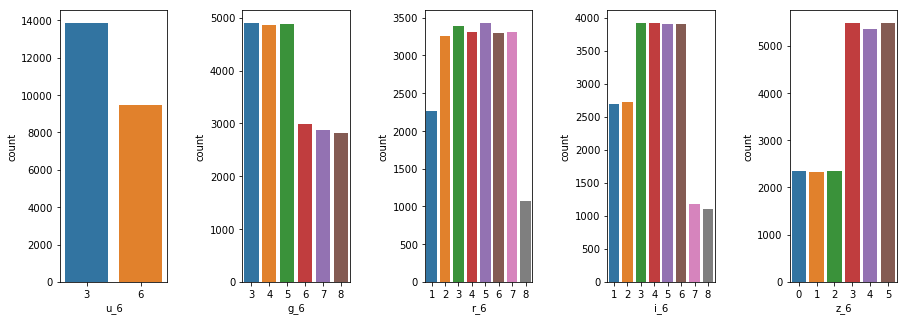

In [24]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.subplots_adjust(wspace=0.7)

for i, b in enumerate(bands_all):
    f_name = "{}_6".format(b)
    sns.countplot(x=f_name, data=unlabeled, ax=ax[i])

In [124]:
for i, b in enumerate(bands_all):
    f_name = "{}_6".format(b)
    print(f_name)
    print(np.sort(train[f_name].unique()))
    print(np.sort(validation[f_name].unique()))
    

u_6
[0 3 6]
[0 3 6]
g_6
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
r_6
[1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
i_6
[1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
z_6
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]


#### 'Clean' column and object in frame characteristics 

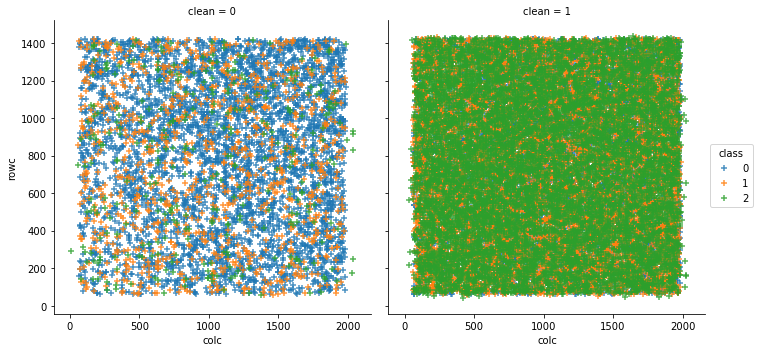

In [25]:
sns.lmplot(x='colc', y='rowc', data=train, col='clean', hue='class', fit_reg=False, markers="+")

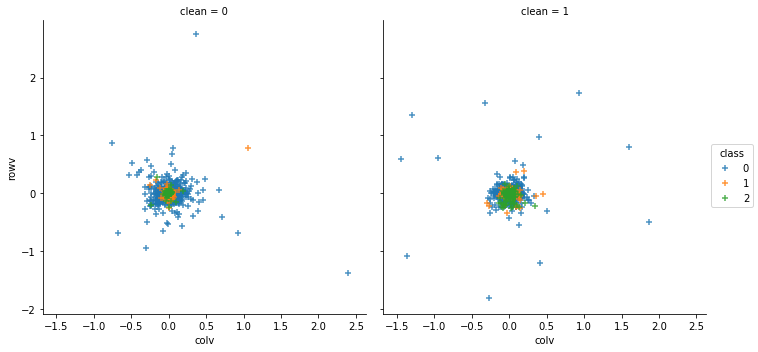

In [26]:
sns.lmplot(x='colv', y='rowv', data=train, col='clean', hue='class', fit_reg=False, markers="+")

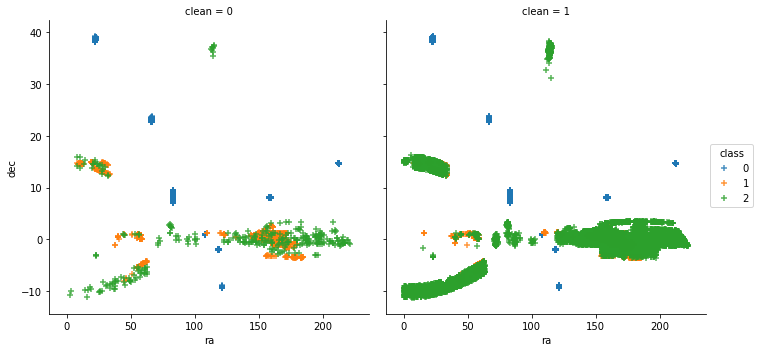

In [27]:
# since ra\dec coordinates in train and validation set are completly different I'm not sure if this is worth checking
sns.lmplot(x='ra', y='dec', data=train, col='clean', hue='class', fit_reg=False, markers="+")

clean  class
0      0        3987
       1         959
       2         329
1      2        9671
       1        9041
       0        6013
Name: class, dtype: int64

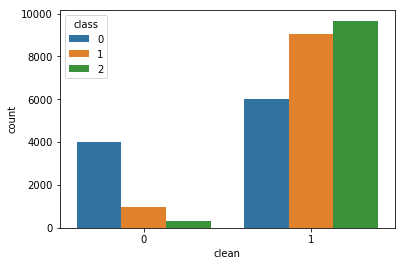

In [28]:
sns.countplot(x='clean', hue='class', data=train)
train.groupby('clean')['class'].value_counts()

'Cleanliness' of the shot doesn't depend on neither object's velocity in frame nor coordinates of object in frame.  
Elements of 1st class has much more clean shots than 'dirty' ones.  

### Conclusion  
  * 3-rd, 4-th and 5-th features are probably not usefull: a lot of missing values, outliers and nearly the same values for different classes
  * Outliers in 3-rd, 4-th and 5-th features are not caused by 'dirty' shots and happen more often in elements of 1 class    
  * 0-th feature may be usefull, but has a lot of missing values. There is a chance to predict NaNs from present 0-th features
  * 1-st and 2-nd features are perfectly correlated (pearsons_r = 1) with 'rowc' and 'colc'
  * Samples of 1-st and 2-nd class are more likely to be captured in clean shot

## Missing values

In [8]:
show_missing_values()

,train,validation,unlabeled
u_0,4556,3455,0
g_0,4504,3460,0
r_0,4555,3380,0
i_0,4596,3449,0
z_0,4481,3499,0
rowv,401,681,621
colv,401,681,621
u_3,5173,4836,4935
g_3,1720,1690,1760
r_3,727,752,778


Unlabeled data has less missing values then training and validationing sets.  
Columns '-0', '-3', '-4', '-5' in training set has ~13-15% missing values.  
  
  As I said before, let's try to predict 0-th features from present 0-th features 

#### 0-th feature

Check how many 0-th features are missing at the same time in train dataset

0    13266
1    11664
2     4248
3      764
4       50
5        8
dtype: int64


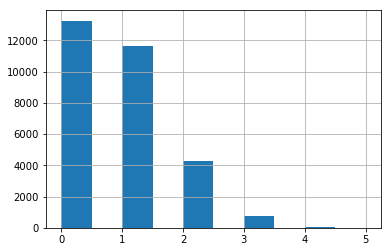

In [125]:
zeros_features = ["{}_0".format(b) for b in bands_all]
num_of_missing_0th = train[zeros_features].isna().sum(axis=1)

print(num_of_missing_0th.value_counts())
num_of_missing_0th.hist()

A few samples have all 0-th features missing, so after 'regression' prediction we still have to fill NaNs with mean values.

In [126]:
train[zeros_features].corr()

,u_0,g_0,r_0,i_0,z_0
u_0,1.000000,0.817264,0.717657,0.631143,0.617691
g_0,0.817264,1.000000,0.901610,0.816336,0.782590
r_0,0.717657,0.901610,1.000000,0.931553,0.873073
i_0,0.631143,0.816336,0.931553,1.000000,0.896410
z_0,0.617691,0.782590,0.873073,0.896410,1.000000


In [127]:
unlabeled[zeros_features].corr()

,u_0,g_0,r_0,i_0,z_0
u_0,1.000000,0.775498,0.682887,0.605890,0.590848
g_0,0.775498,1.000000,0.898527,0.816628,0.768118
r_0,0.682887,0.898527,1.000000,0.915039,0.853865
i_0,0.605890,0.816628,0.915039,1.000000,0.866295
z_0,0.590848,0.768118,0.853865,0.866295,1.000000


Prediction of every feature should be based on the most correlated variable:
* u_0 based on g_0  
* g_0 based on r_0  
* r_0 based on i_0  
* i_0 based on r_0  
* z_0 based on i_0  

In [128]:
def fill_nans_based_on_regression(col, based_on_col, data):
    print("\n{} based on {}".format(col, based_on_col))
    
    # get only notna values to train linear regression
    clean_columns_mask = data[[col, based_on_col]].notna().all(axis=1)
    clean_columns = data[clean_columns_mask][[col, based_on_col]]
    
    # get samples where 'col' is NaN and 'based_col' is not NaN
    # (samples, where 'col' value will be predicted)
    col_nan_mask = data[col].isna()
    based_col_notna_mask = data[based_on_col].notna()
    samples_to_predict = data[col_nan_mask & based_col_notna_mask]
    
    # reshape to fit the regression
    X = clean_columns[based_on_col].values.reshape(-1, 1)
    y = clean_columns[col].values.reshape(-1, 1)
    to_predict = samples_to_predict[based_on_col].values.reshape(-1, 1)
    
    reg = LinearRegression()
    reg.fit(X, y)
    print("reg score: {}".format(reg.score(X, y)))
    
    predicted = reg.predict(to_predict).flatten()
    
    num_of_nans_before = data[col].isna().sum()
    
    # fill predicted values instead of NaNs
    idx = samples_to_predict.index
    data.loc[idx, col] = predicted
    
    num_of_nans_after = data[col].isna().sum()
    print("replaced {} NaN values".format(num_of_nans_before - num_of_nans_after))

In [129]:
replacement_scheme = [('r_0', 'i_0'), ('i_0', 'r_0'), ('z_0', 'r_0'), ('g_0', 'r_0'), ('u_0', 'g_0')]

for col, based_on_col in replacement_scheme:
    fill_nans_based_on_regression(col, based_on_col, train)

for col, based_on_col in replacement_scheme:
    fill_nans_based_on_regression(col, based_on_col, validation)


r_0 based on i_0
reg score: 0.8677907744593449
replaced 3885 NaN values

i_0 based on r_0
reg score: 0.8856728999444379
replaced 3926 NaN values

z_0 based on r_0
reg score: 0.7625302248742643
replaced 4377 NaN values

g_0 based on r_0
reg score: 0.7919346700916082
replaced 4402 NaN values

u_0 based on g_0
reg score: 0.6422382303904675
replaced 4540 NaN values

r_0 based on i_0
reg score: 0.8407839811848895
replaced 2854 NaN values

i_0 based on r_0
reg score: 0.8608835564380372
replaced 2923 NaN values

z_0 based on r_0
reg score: 0.7446820857487215
replaced 3416 NaN values

g_0 based on r_0
reg score: 0.8010923400872132
replaced 3376 NaN values

u_0 based on g_0
reg score: 0.5750493514492977
replaced 3440 NaN values


In [130]:
show_missing_values()

,train,validation,unlabeled
u_0,16,15,0
g_0,102,84,0
r_0,670,526,0
i_0,670,526,0
z_0,104,83,0
rowv,401,681,621
colv,401,681,621
u_3,5173,4836,4935
g_3,1720,1690,1760
r_3,727,752,778


Fill all the rest 0-th features with mean values by columns

In [131]:
train[zeros_features] = train[zeros_features].fillna(train[zeros_features].mean())
validation[zeros_features] = validation[zeros_features].fillna(validation[zeros_features].mean())

train[zeros_features].isna().sum().max(), validation[zeros_features].isna().sum().max() 

(0, 0)

#### 1-st, 2-nd color features

In [132]:
# eventually delete 1-st and 2-nd features 
bands = ['u', 'g', 'r', 'i', 'z']
indx = ['1', '2']
columns_to_drop = ["{}_{}".format(b, i) for b in bands for i in indx]

train = train.drop(columns_to_drop, axis=1)
validation = validation.drop(columns_to_drop, axis=1)

unlabeled = unlabeled.drop(columns_to_drop, axis=1)

#### 3-rd, 4-th and 5-th features

In [133]:
# just fill nans with median value
bands = ['u', 'g', 'r', 'i', 'z']
indx = ['3', '4', '5']
columns_to_fill = ["{}_{}".format(b, i) for b in bands for i in indx]

train[columns_to_fill] = train[columns_to_fill].fillna(train[columns_to_fill].median())
validation[columns_to_fill] = validation[columns_to_fill].fillna(validation[columns_to_fill].median())
unlabeled[columns_to_fill] = unlabeled[columns_to_fill].fillna(unlabeled[columns_to_fill].median())

train[columns_to_fill].isna().sum().max(), validation[columns_to_fill].isna().sum().max() 

(0, 0)

#### colv and rowv features

For now we have only 'rowv' and 'colv' missing values  

In [134]:
show_missing_values()

,train,validation,unlabeled
rowv,401,681,621
colv,401,681,621


In [18]:
train[['rowv', 'colv']].isna().all(axis=1).value_counts()

False    29599
True       401
dtype: int64

In [19]:
unlabeled[['rowv', 'colv']].isna().all(axis=1).value_counts()

False    22712
True       621
dtype: int64

Columns are both missing or both present in train and unlabeled datasets. Assume, the same situation is in the validation set.   
       
As we checked before, columns are probably not relevant to class prediction

In [135]:
train.fillna(train.mean(), inplace=True)
validation.fillna(validation.mean(), inplace=True)
unlabeled.fillna(unlabeled.mean(), inplace=True)

In [136]:
train.isna().sum().max(), validation.isna().sum().max()

(0, 0)

In [137]:
train.shape, validation.shape

((30000, 34), (23333, 34))

### Conclusion

*  Fill  '-3', '-4', '-5'  columns with median value due to ~13-15% of missing values and ~10-20% outliers
*  Fill '-0' columns with regression results based on present '-0' features
*  Fill all remaining '-0' NaNs with mean values
*  Replace 'rowv' and 'colv' NaNs with mean values

# Prediction

In [138]:
train_copy = train.copy()
val_copy = validation.copy()

In [139]:
# '-6' are categorical variables and need to be converted

features = ["{}_6".format(b) for b in bands_all]

dummy_train = pd.DataFrame()
dummy_val = pd.DataFrame()
for f in features:   
    dummy_train = pd.concat([dummy_train, pd.get_dummies(train[f], prefix=f)], axis=1)    
    dummy_val = pd.concat([dummy_val, pd.get_dummies(validation[f], prefix=f)], axis=1)

# in case test set has values train set doesn't have
values = ["{}_{}".format(f, i) for f in features for i in range(9)]

dummy_train = dummy_train.reindex(columns=values).fillna(0).astype('int64')
dummy_val = dummy_val.reindex(columns=values).fillna(0).astype('int64')

train = pd.concat([train, dummy_train], axis=1)
validation = pd.concat([validation, dummy_val], axis=1)

# drop initial categorical variables
train.drop(features, axis=1, inplace=True)
validation.drop(features, axis=1, inplace=True)

In [140]:
X_train = train.drop(['objid', 'class'], axis=1)
y_train = train['class']

X_test = validation.drop(['objid', 'class'], axis=1)
y_test = validation['class']

colummn_names = X_train.columns

In [141]:
do_plot=False

def try_classifier(clf, params=None):
    if not params is None:
        print(params)
        clf.set_params(**params)
    start = time.time()
    
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    
    end = time.time()
    print("{0:.2f} sec".format((end - start)))
    
    print("f1-score: {}".format(f1_score(y_test, prediction, average='macro')))
    
    cm = confusion_matrix(y_test, prediction)
    if do_plot:
        sns.heatmap(cm, annot=True, fmt="d")
        plt.show()
    

In [142]:
def try_with_all_classifiers():
    print("Decision Tree classifier: ")
    try_classifier(DecisionTreeClassifier())
    try_classifier(DecisionTreeClassifier(), {"min_samples_split": 230})
    
    print("\nLogistic Regression: ")
    try_classifier(LogisticRegression())
    try_classifier(LogisticRegression(), {'multi_class': 'multinomial', 'solver': 'newton-cg', 'max_iter': 100})
    
    print("\nRandom Forest classifier: ")
    try_classifier(RandomForestClassifier())
    try_classifier(RandomForestClassifier(), {"min_samples_split": 200, "n_estimators": 30})
    
    print("\nK Neighbors Classifier: ")
    try_classifier(KNeighborsClassifier())

In [74]:
try_with_all_classifiers()

Decision Tree classifier: 
1.29 sec
f1-score: 0.4203049985084854
{'min_samples_split': 230}
1.04 sec
f1-score: 0.4372874617088985

Logistic Regression: 
9.76 sec
f1-score: 0.44294232488961066
{'multi_class': 'multinomial', 'max_iter': 100, 'solver': 'newton-cg'}


C:\Users\Alina\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


59.23 sec
f1-score: 0.5694635267422089

Random Forest claffisier: 
1.49 sec
f1-score: 0.5654848158948684
{'n_estimators': 30, 'min_samples_split': 200}
4.16 sec
f1-score: 0.5488206817858211

K Neighbors Classifier: 
26.45 sec
f1-score: 0.27685542753655584


In [111]:
# try scalling data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [86]:
try_with_all_classifiers()

Decision Tree classifier: 
1.32 sec
f1-score: 0.4211291055912756
{'min_samples_split': 230}
1.60 sec
f1-score: 0.4372874617088985

Logistic Regression: 
2.83 sec
f1-score: 0.548264162496289
{'multi_class': 'multinomial', 'max_iter': 100, 'solver': 'newton-cg'}
4.56 sec
f1-score: 0.571182322066349

Random Forest claffisier: 
1.28 sec
f1-score: 0.6042392573205929
{'n_estimators': 30, 'min_samples_split': 200}
3.24 sec
f1-score: 0.5525020645932579

K Neighbors Classifier: 
157.70 sec
f1-score: 0.6399269321111787


In [143]:
# determine most important features

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

for i, idx in enumerate(indices):
    print("{}: {} {}".format(i, colummn_names[idx], importances[idx]))

0: g_0 0.11514114082883509
1: dec 0.10859294973698033
2: ra 0.10225738788967949
3: z_0 0.09539115289670823
4: i_0 0.06601802252401412
5: u_0 0.05582370279566469
6: r_0 0.050208361422194446
7: i_3 0.026994274252615986
8: r_3 0.026526367960862062
9: u_3 0.026224778409580825
10: g_3 0.01882975595139271
11: z_3 0.018201553147443154
12: clean 0.017815957826384517
13: g_4 0.016736413923129505
14: g_5 0.01622300645411505
15: colv 0.015444336201651731
16: u_6_3 0.01404333564405301
17: r_4 0.013125605696165643
18: rowv 0.012938738353371207
19: g_6_4 0.012571272877958058
20: u_6_6 0.011469327558376933
21: g_6_3 0.01099674312776914
22: i_5 0.010519514334840014
23: z_4 0.010314149981497631
24: u_4 0.010237100613396008
25: i_4 0.010109160683451277
26: g_6_8 0.009959295141479798
27: r_5 0.009929539810226526
28: colc 0.009711106850928516
29: g_6_5 0.00925432107017722
30: u_5 0.009250059492637738
31: rowc 0.009103771315730938
32: g_6_6 0.008915611277223288
33: z_5 0.00860863713434842
34: g_6_7 0.00618

In [145]:
# kill -6th feature
features = ["{}_6".format(b) for b in bands_all]

X_train = train_copy.drop(['objid', 'class', *features], axis=1)
y_train = train['class']

X_test = val_copy.drop(['objid', 'class', *features], axis=1)
y_test = validation['class']
# not a win

In [147]:
try_with_all_classifiers()

Decision Tree classifier: 
1.30 sec
f1-score: 0.4223716211898516
{'min_samples_split': 230}
1.01 sec
f1-score: 0.4370882591400142

Logistic Regression: 
13.11 sec
f1-score: 0.4491069463008355
{'multi_class': 'multinomial', 'max_iter': 100, 'solver': 'newton-cg'}


C:\Users\Alina\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Alina\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


45.84 sec
f1-score: 0.5301919942891741

Random Forest classifier: 
1.67 sec
f1-score: 0.3655026623709688
{'n_estimators': 30, 'min_samples_split': 200}
3.92 sec
f1-score: 0.39311261278379767

K Neighbors Classifier: 
14.59 sec
f1-score: 0.2768887447517365


In [148]:
# try scalling data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [149]:
try_with_all_classifiers()

Decision Tree classifier: 
1.11 sec
f1-score: 0.42235092199309543
{'min_samples_split': 230}
0.92 sec
f1-score: 0.4370882591400142

Logistic Regression: 
0.84 sec
f1-score: 0.5166839595368123
{'multi_class': 'multinomial', 'max_iter': 100, 'solver': 'newton-cg'}
1.42 sec
f1-score: 0.5301836076393704

Random Forest classifier: 
1.48 sec
f1-score: 0.35399282139553595
{'n_estimators': 30, 'min_samples_split': 200}
4.28 sec
f1-score: 0.3869784024701827

K Neighbors Classifier: 
62.87 sec
f1-score: 0.5404563125197578


1.22 sec
f1-score: 0.42073332943017167


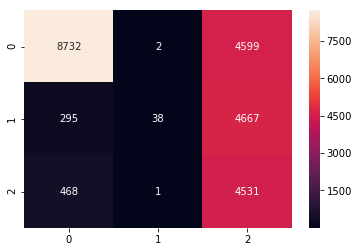

In [42]:
try_classifier(DecisionTreeClassifier())

{'min_samples_split': 2}
1.36 sec
f1-score: 0.42129678051278546


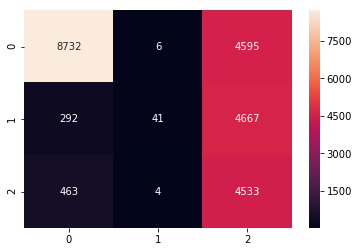

{'min_samples_split': 10}
1.44 sec
f1-score: 0.42080253691046793


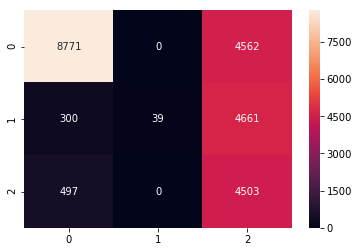

{'min_samples_split': 50}
2.07 sec
f1-score: 0.41912285648116215


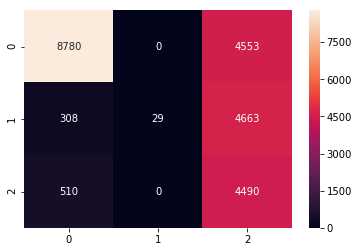

{'min_samples_split': 100}
1.96 sec
f1-score: 0.42378606894207577


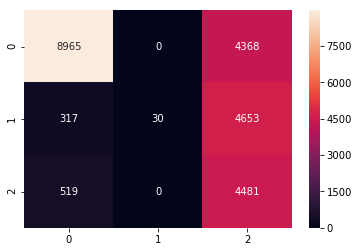

{'min_samples_split': 150}
2.06 sec
f1-score: 0.4373870291563547


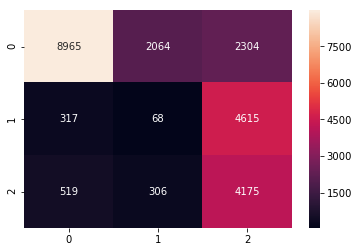

{'min_samples_split': 200}
2.14 sec
f1-score: 0.4373870291563547


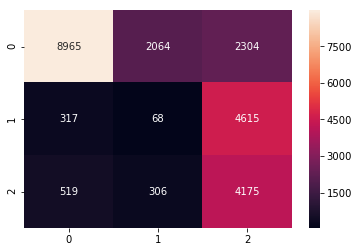

{'min_samples_split': 230}
2.53 sec
f1-score: 0.4373870291563547


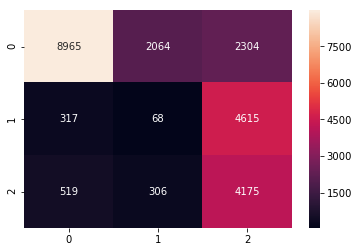

{'min_samples_split': 250}
1.56 sec
f1-score: 0.4372874617088985


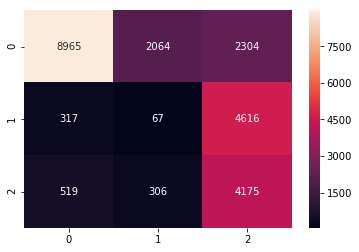

In [60]:
# ~230-250
params = {
    "min_samples_split": [2, 10, 50, 100, 150, 200, 230, 250]
}

grid = ParameterGrid(params)

for ps in grid:
    try_classifier(DecisionTreeClassifier(), ps)

22.75 sec
f1-score: 0.27685542753655584


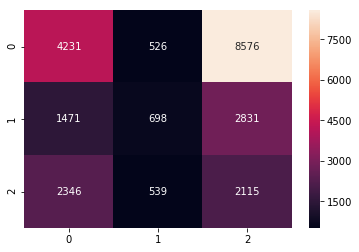

In [65]:
try_classifier(KNeighborsClassifier())

In [ ]:
# never again
# try_classifier(LinearSVC(), {'multi_class':'crammer_singer'})

f1-score: 0.44294232488961066


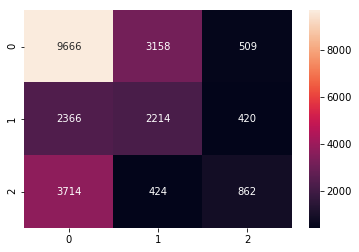

In [36]:
try_classifier(LogisticRegression())

[{'multi_class': 'multinomial', 'solver': 'lbfgs'}, {'multi_class': 'multinomial', 'solver': 'sag'}, {'multi_class': 'multinomial', 'solver': 'newton-cg'}, {'multi_class': 'ovr', 'solver': 'lbfgs'}, {'multi_class': 'ovr', 'solver': 'sag'}, {'multi_class': 'ovr', 'solver': 'newton-cg'}, {'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}, {'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}]
{'multi_class': 'multinomial', 'solver': 'lbfgs'}
1.80 sec
f1-score: 0.4423817699309332


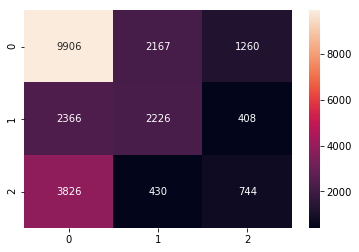

{'multi_class': 'multinomial', 'solver': 'sag'}


C:\Users\Alina\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


5.78 sec
f1-score: 0.36885424847806453


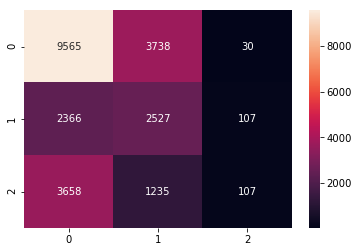

{'multi_class': 'multinomial', 'solver': 'newton-cg'}


C:\Users\Alina\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


59.15 sec
f1-score: 0.5694635267422089


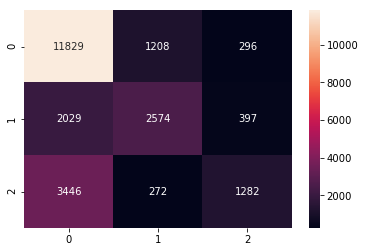

{'multi_class': 'ovr', 'solver': 'lbfgs'}
1.74 sec
f1-score: 0.46858407171155725


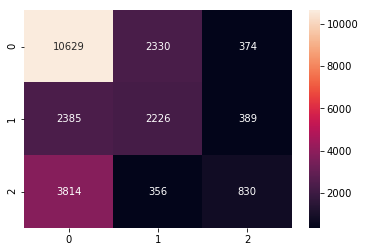

{'multi_class': 'ovr', 'solver': 'sag'}


C:\Users\Alina\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


10.04 sec
f1-score: 0.3618886592198148


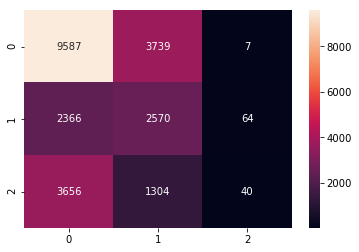

{'multi_class': 'ovr', 'solver': 'newton-cg'}


C:\Users\Alina\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Alina\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


41.61 sec
f1-score: 0.5478936193055702


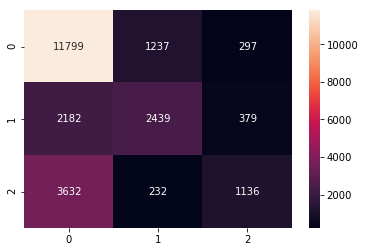

{'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
69.04 sec
f1-score: 0.5458040678920665


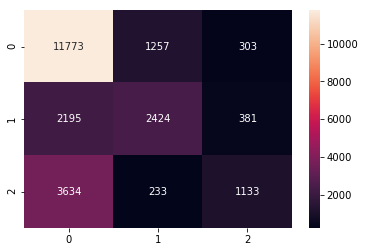

{'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
8.99 sec
f1-score: 0.44294232488961066


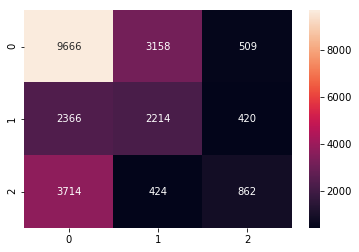

In [54]:
params = [
    {'multi_class': ['multinomial', 'ovr'], 'solver': ['lbfgs', 'sag', 'newton-cg']},
    {'multi_class': ['ovr'], 'solver': ['liblinear'], 'penalty': ['l1', 'l2']}
]

grid = ParameterGrid(params)

for ps in grid:
    try_classifier(LogisticRegression(), ps)

{'multi_class': 'multinomial', 'max_iter': 350, 'solver': 'newton-cg'}


C:\Users\Alina\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


265.03 sec
f1-score: 0.5707815065587697


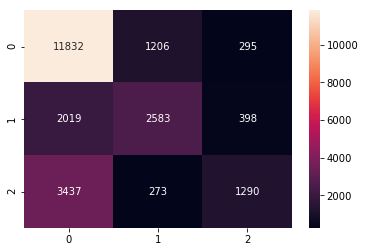

In [55]:
params = {
    'multi_class': 'multinomial',
    'solver': 'newton-cg',
    'max_iter': 250
}

try_classifier(LogisticRegression(), params)

In [57]:
validation['class'].value_counts()

0    13333
2     5000
1     5000
Name: class, dtype: int64

{'n_estimators': 10, 'min_samples_split': 100}
1.22 sec
f1-score: 0.5721019132742259


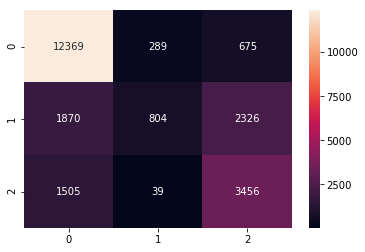

{'n_estimators': 30, 'min_samples_split': 100}
3.21 sec
f1-score: 0.5464581028426453


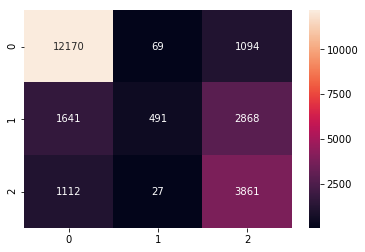

{'n_estimators': 50, 'min_samples_split': 100}
7.00 sec
f1-score: 0.5106077427001376


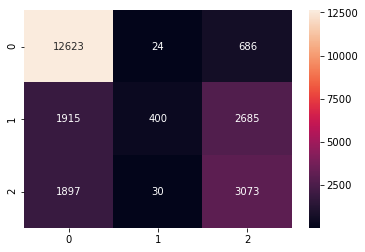

{'n_estimators': 100, 'min_samples_split': 100}
10.63 sec
f1-score: 0.5310540567776759


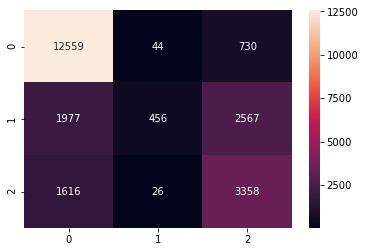

{'n_estimators': 150, 'min_samples_split': 100}
17.57 sec
f1-score: 0.5034173979290394


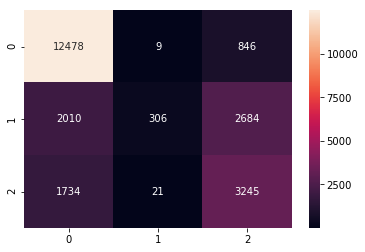

{'n_estimators': 200, 'min_samples_split': 100}
22.28 sec
f1-score: 0.518310357616903


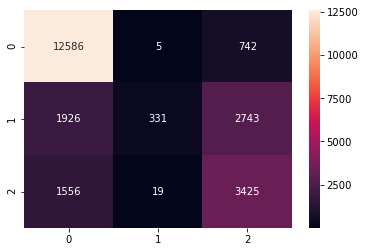

{'n_estimators': 10, 'min_samples_split': 150}
2.16 sec
f1-score: 0.5653255612550594


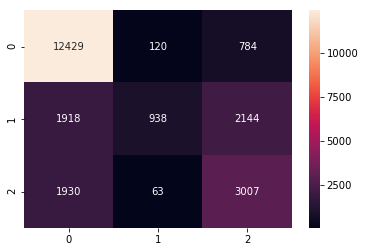

{'n_estimators': 30, 'min_samples_split': 150}
4.33 sec
f1-score: 0.5615551064864348


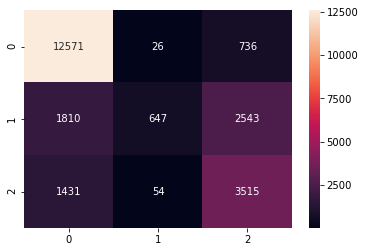

{'n_estimators': 50, 'min_samples_split': 150}
7.00 sec
f1-score: 0.5630611287638012


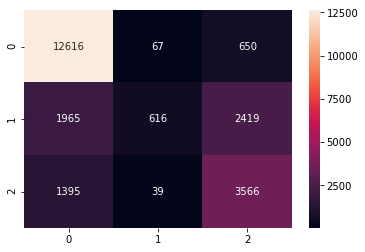

{'n_estimators': 100, 'min_samples_split': 150}
11.03 sec
f1-score: 0.5675020598770364


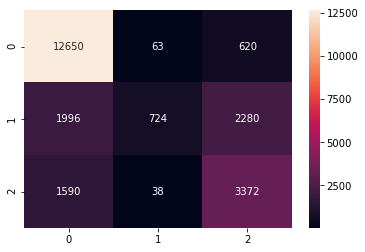

{'n_estimators': 150, 'min_samples_split': 150}
17.01 sec
f1-score: 0.5077668488644816


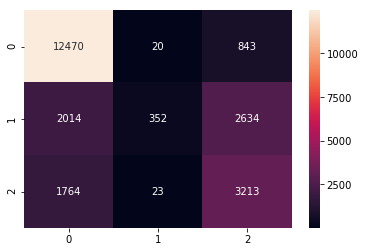

{'n_estimators': 200, 'min_samples_split': 150}
22.40 sec
f1-score: 0.540331314430901


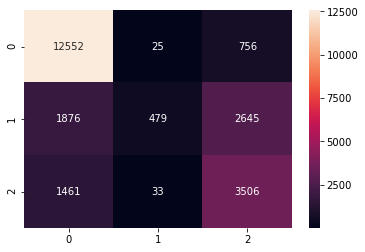

{'n_estimators': 10, 'min_samples_split': 200}
1.23 sec
f1-score: 0.5948746102874556


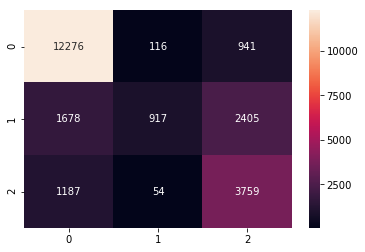

{'n_estimators': 30, 'min_samples_split': 200}
3.42 sec
f1-score: 0.6064395520093664


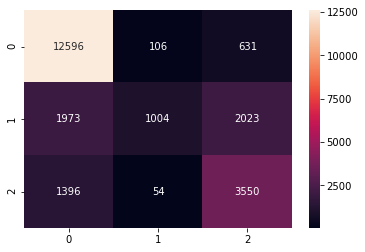

{'n_estimators': 50, 'min_samples_split': 200}
6.03 sec
f1-score: 0.5270526651572065


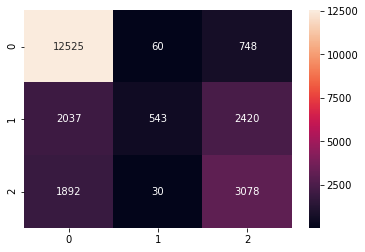

{'n_estimators': 100, 'min_samples_split': 200}
10.08 sec
f1-score: 0.5408285338334752


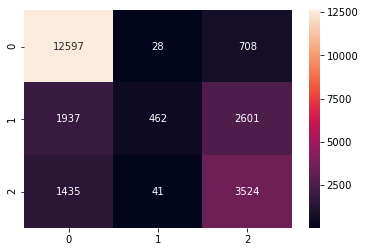

{'n_estimators': 150, 'min_samples_split': 200}
16.60 sec
f1-score: 0.5583910487817644


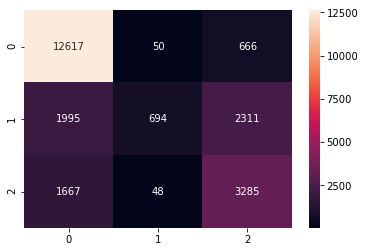

{'n_estimators': 200, 'min_samples_split': 200}
22.74 sec
f1-score: 0.5299610354818687


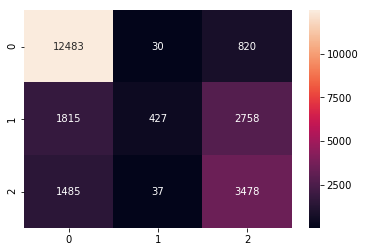

{'n_estimators': 10, 'min_samples_split': 230}
0.93 sec
f1-score: 0.5786040307626323


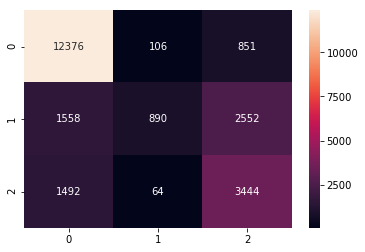

{'n_estimators': 30, 'min_samples_split': 230}
3.09 sec
f1-score: 0.5930099162771048


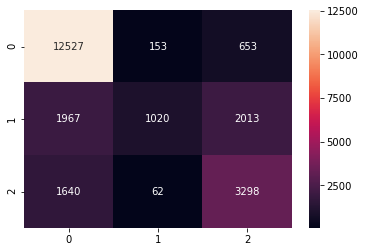

{'n_estimators': 50, 'min_samples_split': 230}
7.03 sec
f1-score: 0.5410166449394428


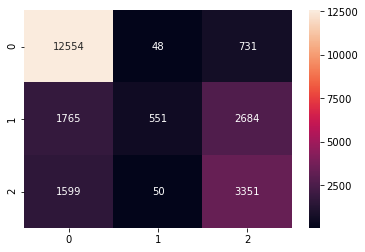

{'n_estimators': 100, 'min_samples_split': 230}
11.77 sec
f1-score: 0.5233427638049929


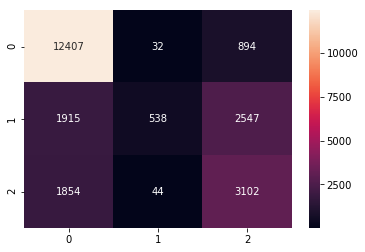

{'n_estimators': 150, 'min_samples_split': 230}
13.83 sec
f1-score: 0.583066401225007


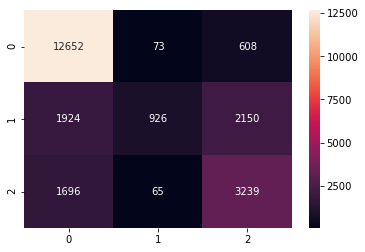

{'n_estimators': 200, 'min_samples_split': 230}
24.09 sec
f1-score: 0.5204386468121078


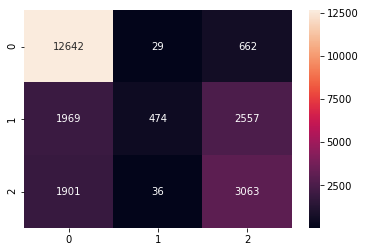

{'n_estimators': 10, 'min_samples_split': 250}
0.90 sec
f1-score: 0.5586553594868211


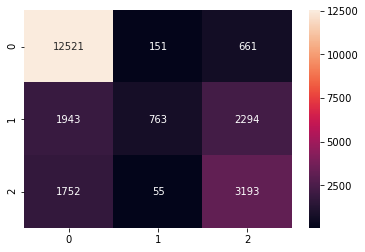

{'n_estimators': 30, 'min_samples_split': 250}
2.77 sec
f1-score: 0.5303683021437738


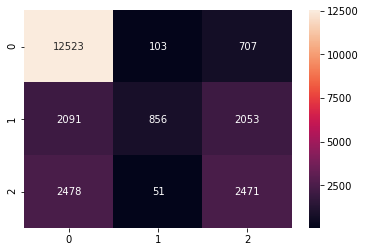

{'n_estimators': 50, 'min_samples_split': 250}
8.33 sec
f1-score: 0.5478219327684865


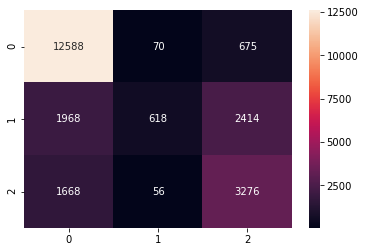

{'n_estimators': 100, 'min_samples_split': 250}
10.12 sec
f1-score: 0.5777978617054328


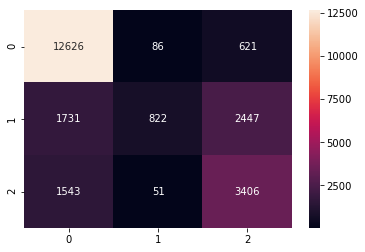

{'n_estimators': 150, 'min_samples_split': 250}
16.00 sec
f1-score: 0.585610533472341


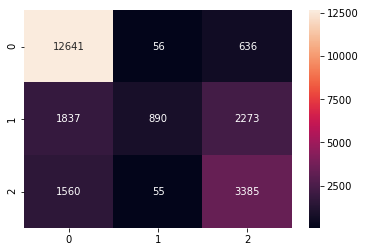

{'n_estimators': 200, 'min_samples_split': 250}
18.95 sec
f1-score: 0.5441373490600654


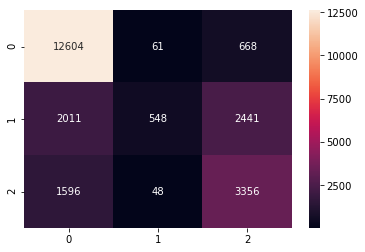

In [62]:
# 200 30
params = {
    "min_samples_split": [100, 150, 200, 230, 250],
    "n_estimators": [10, 30, 50, 100]
}

grid = ParameterGrid(params)

for ps in grid:
    try_classifier(RandomForestClassifier(), ps)